In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays

In [140]:
#df_cons = pd.read_excel('datasets/Actual_consumption_202001010000_202011242359.xlsx', skiprows=6,na_values='-')
#df_price = pd.read_excel('datasets/Day-ahead_prices_202001010000_202011242359.xlsx', skiprows=6, na_values='-')
#df_gen = pd.read_excel('datasets/Actual_generation_202001010000_202011242359.xlsx', skiprows=6, na_values='-')

df_cons = pd.read_excel('datasets/Actual_consumption_201901010000_202011302359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_test = pd.read_excel('datasets/Day-ahead_prices_202012010000_202012312359.xlsx', skiprows=6, na_values='-')


#Concatenate Date + Time and create TimeSeries
df_cons['Date'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time of day'])
#Create Timeseries index for 
#Drop Unused column
df_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Repeat the same steps for Prices Dataset
df_price['Date'] = pd.to_datetime(df_price['Date'] + ' ' + df_price['Time of day'])
df_price.set_index('Date', inplace=True)
df_price.drop(df_price.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_price['Germany/Luxembourg[€/MWh]'] = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Test Dataset
df_test['Date'] = pd.to_datetime(df_test['Date'] + ' ' + df_test['Time of day'])
df_test.set_index('Date', inplace=True)
df_test.drop(df_test.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_test['Germany/Luxembourg[€/MWh]'] = df_test[df_test['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Power Generation Dataset 
df_gen['Date'] = pd.to_datetime(df_gen['Date'] + ' ' + df_gen['Time of day'])
df_gen.drop('Time of day', axis=1, inplace=True)
df_gen.set_index('Date', inplace=True)

#Create the Total Power Generation Column also known as Sypply
df_gen['TotalGeneration[MWh]'] = (df_gen['Biomass[MWh]'] + 
        df_gen['Hydropower[MWh]']+
        df_gen['Wind offshore[MWh]'] +
        df_gen['Wind onshore[MWh]']+
        df_gen['Photovoltaics[MWh]']+
        df_gen['Other renewable[MWh]']+ 
        df_gen['Nuclear[MWh]']+ 
        df_gen['Fossil brown coal[MWh]']+
        df_gen['Fossil hard coal[MWh]']+ 
        df_gen['Fossil gas[MWh]']+ 
        df_gen['Hydro pumped storage[MWh]']+
        df_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_gen['TotalGeneration[MWh]']/=1000  
df_gen['Biomass[MWh]']/=1000
df_gen['Hydropower[MWh]']/=1000
df_gen['Wind offshore[MWh]']/=1000
df_gen['Wind onshore[MWh]']/=1000
df_gen['Photovoltaics[MWh]']/=1000
df_gen['Other renewable[MWh]']/=1000
df_gen['Nuclear[MWh]']/=1000
df_gen['Fossil brown coal[MWh]']/=1000
df_gen['Fossil hard coal[MWh]']/=1000
df_gen['Fossil gas[MWh]']/=1000
df_gen['Hydro pumped storage[MWh]']/=1000
df_gen['Other conventional[MWh]']/=1000

df_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)


#Downsample datasets to a daily frequency 
df_dcons = df_cons.resample('D').sum()
df_dgen = df_gen.resample('D').sum()
df_dprice = df_price.resample('D').median()
df_test = df_test.resample('D').median()

#Merge Datasets into a single one
df = pd.merge(df_dcons, df_dgen, left_index=True, right_index=True )
df = pd.merge(df, df_dprice, left_index=True, right_index=True )

#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
#Calculate Supply-Demand Index
df['SupplyDemandIndex[SDI]'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

#Window of 90 Days
window = 90

#remove rolls without prices
df = df[~df['Germany/Luxembourg[€/MWh]'].isnull()]
df['PriceDeviation'] = df['Germany/Luxembourg[€/MWh]'].rolling(window).std(win_type='gaussian')
#For displaying purpose
df['Non-base Demand[10GWh]'] = df['Non-base Demand[GWh]'] / 10

#Calculate Price Spike
df['PriceSpike'] =  df['Germany/Luxembourg[€/MWh]'] > df['Germany/Luxembourg[€/MWh]'].rolling(window).mean() + df['PriceDeviation'] * 2

<AxesSubplot:xlabel='Date'>

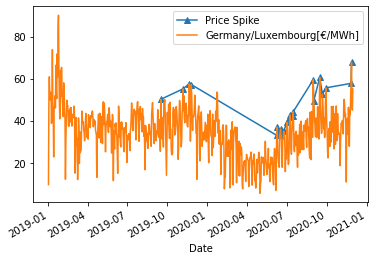

In [141]:
df[df['PriceSpike']]['Germany/Luxembourg[€/MWh]'].plot(marker='^',label='Price Spike', legend=True)
df['Germany/Luxembourg[€/MWh]'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

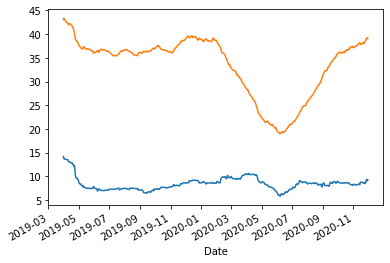

In [142]:
df['PriceDeviation'].plot()
df['Germany/Luxembourg[€/MWh]'].rolling(window).mean().plot()

<AxesSubplot:xlabel='Date'>

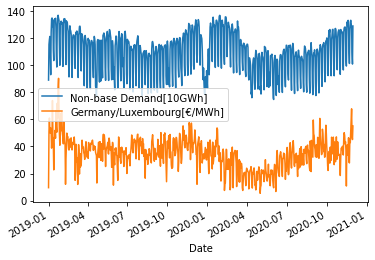

In [143]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

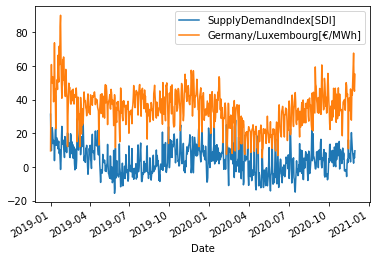

In [144]:
df[['SupplyDemandIndex[SDI]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)


In [145]:
#Skip Temperature and Capacity-Flow for simplicity

<AxesSubplot:xlabel='TotalConsumption[GWh]', ylabel='Germany/Luxembourg[€/MWh]'>

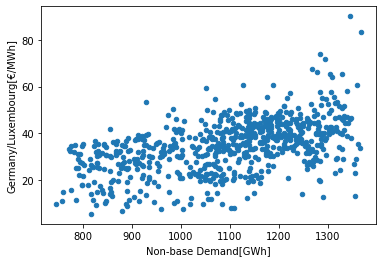

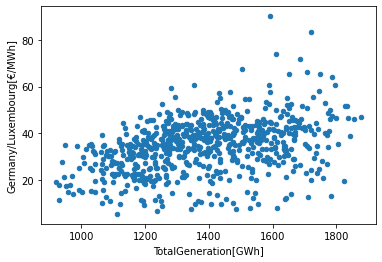

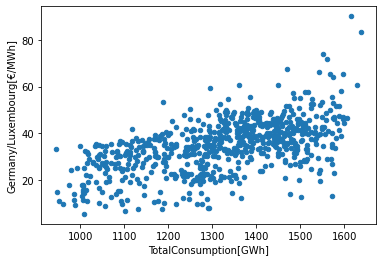

In [146]:
df.plot(kind='scatter', x='Non-base Demand[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalGeneration[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalConsumption[GWh]' ,y='Germany/Luxembourg[€/MWh]' )

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2019-01-01 to 2020-11-30
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TotalConsumption[GWh]      699 non-null    float64
 1   Residual load[MWh]         699 non-null    float64
 2   Biomass[GWh]               699 non-null    float64
 3   Hydropower[GWh]            699 non-null    float64
 4   Wind offshore[GWh]         699 non-null    float64
 5   Wind onshore[GWh]          699 non-null    float64
 6   Photovoltaics[GWh]         699 non-null    float64
 7   Other renewable[GWh]       699 non-null    float64
 8   Nuclear[GWh]               699 non-null    float64
 9   Fossil brown coal[GWh]     699 non-null    float64
 10  Fossil hard coal[GWh]      699 non-null    float64
 11  Fossil gas[GWh]            699 non-null    float64
 12  Hydro pumped storage[GWh]  699 non-null    float64
 13  Other conventional[GWh]    699 

In [148]:
df_normal = df[~df['PriceSpike']].copy()
df_normal.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

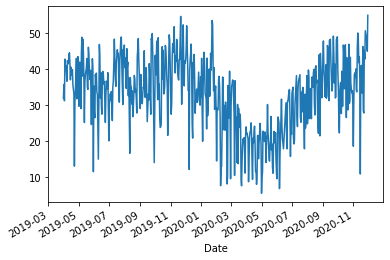

In [149]:
df_normal['Germany/Luxembourg[€/MWh]'].plot()

In [150]:
#Seasonal ARIMA model(SARIMA: Seasonal Auto Regressive Integrated Moving Average) with explanatory variables

from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

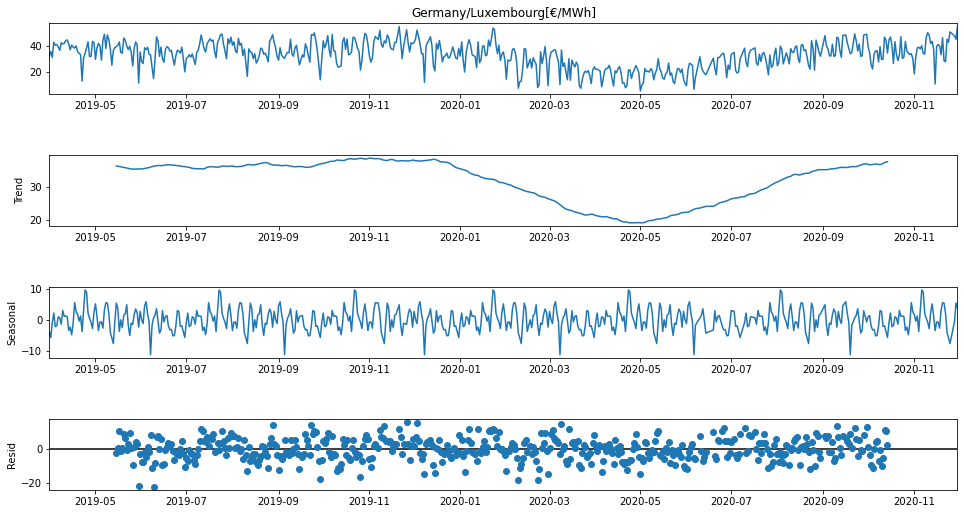

In [151]:
decomposition = seasonal_decompose(df_normal['Germany/Luxembourg[€/MWh]'], period=window)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

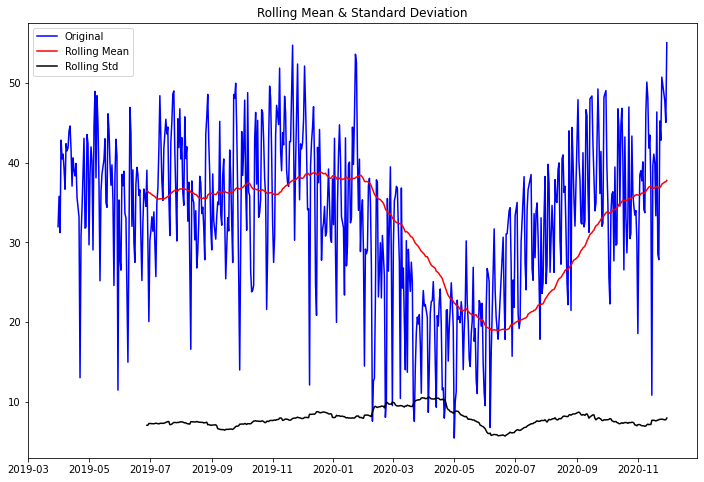

Results of Dickey-Fuller Test:
Test Statistic                  -1.977431
p-value                          0.296556
#Lags Used                      16.000000
Number of Observations Used    570.000000
Critical Value (1%)             -3.441875
Critical Value (5%)             -2.866624
Critical Value (10%)            -2.569478
dtype: float64


In [152]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


test_stationarity(df_normal['Germany/Luxembourg[€/MWh]'])

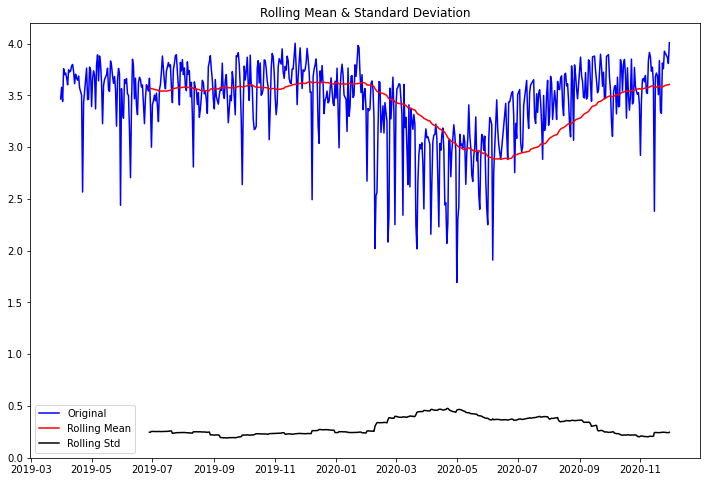

Results of Dickey-Fuller Test:
Test Statistic                  -1.709541
p-value                          0.426204
#Lags Used                      13.000000
Number of Observations Used    573.000000
Critical Value (1%)             -3.441814
Critical Value (5%)             -2.866597
Critical Value (10%)            -2.569463
dtype: float64


In [153]:
df_normal['log(Germany/Luxembourg[€/MWh])']= df_normal['Germany/Luxembourg[€/MWh]'].apply(lambda x: np.log(x))  
test_stationarity(df_normal['log(Germany/Luxembourg[€/MWh])'])
#Worse performance

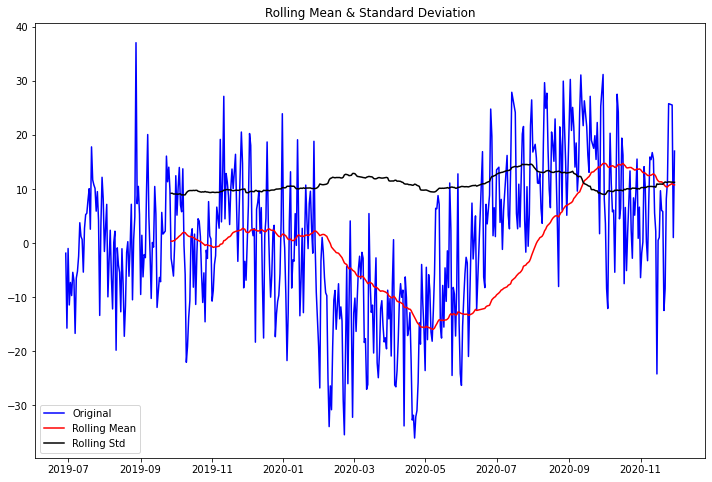

Results of Dickey-Fuller Test:
Test Statistic                  -2.162539
p-value                          0.220122
#Lags Used                      16.000000
Number of Observations Used    480.000000
Critical Value (1%)             -3.444047
Critical Value (5%)             -2.867580
Critical Value (10%)            -2.569987
dtype: float64


In [154]:
df_normal['seasonal_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(window)  
test_stationarity(df_normal['seasonal_difference'].dropna(inplace=False))
#Much better performance

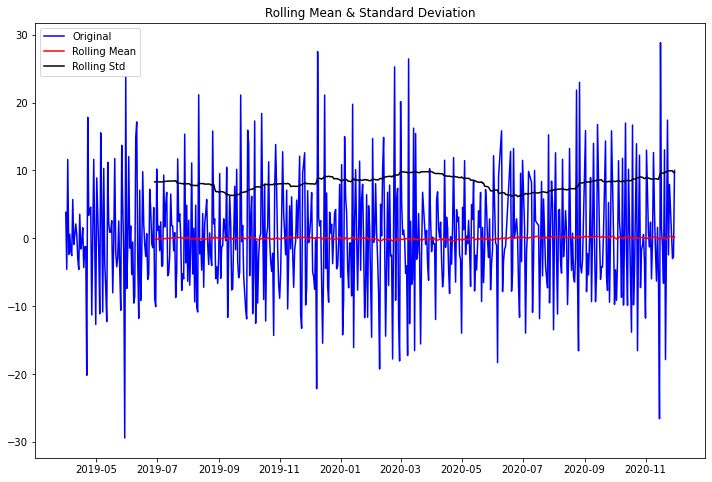

Results of Dickey-Fuller Test:
Test Statistic                -7.848264e+00
p-value                        5.691645e-12
#Lags Used                     1.900000e+01
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.441956e+00
Critical Value (5%)           -2.866660e+00
Critical Value (10%)          -2.569497e+00
dtype: float64


In [155]:
df_normal['first_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(1)  
test_stationarity(df_normal['first_difference'].dropna(inplace=False))
#Very significant p-value
#Data normalised 

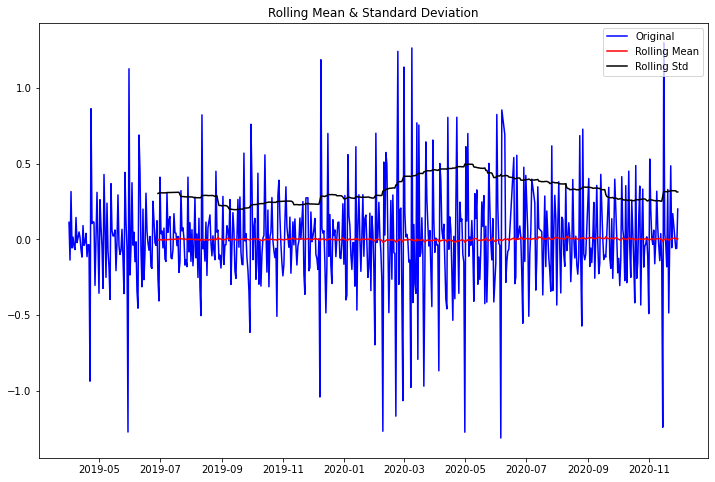

Results of Dickey-Fuller Test:
Test Statistic                -1.242999e+01
p-value                        3.960204e-23
#Lags Used                     1.200000e+01
Number of Observations Used    5.730000e+02
Critical Value (1%)           -3.441814e+00
Critical Value (5%)           -2.866597e+00
Critical Value (10%)          -2.569463e+00
dtype: float64


In [156]:
df_normal['first_difference_log']= df_normal['log(Germany/Luxembourg[€/MWh])'] - df_normal['log(Germany/Luxembourg[€/MWh])'].shift(1)
test_stationarity(df_normal['first_difference_log'].dropna(inplace=False))

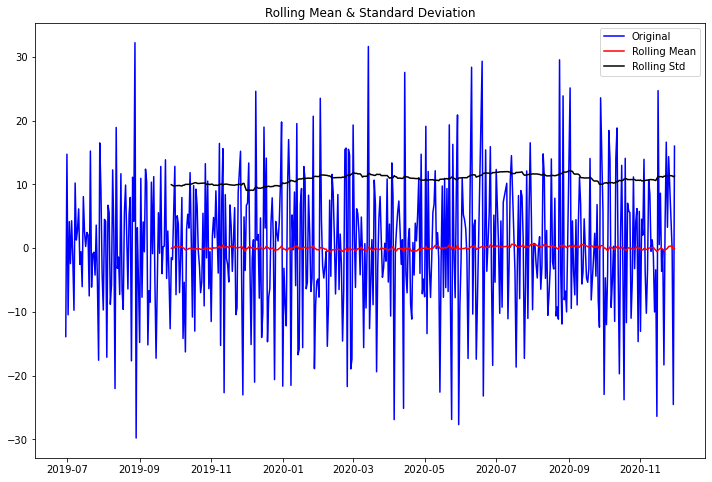

Results of Dickey-Fuller Test:
Test Statistic                -6.503618e+00
p-value                        1.145534e-08
#Lags Used                     1.500000e+01
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


In [157]:
df_normal['seasonal_first_difference'] = df_normal['first_difference'] - df_normal['first_difference'].shift(window)  
test_stationarity(df_normal.seasonal_first_difference.dropna(inplace=False))
#Very Significant but not as much as the previous one

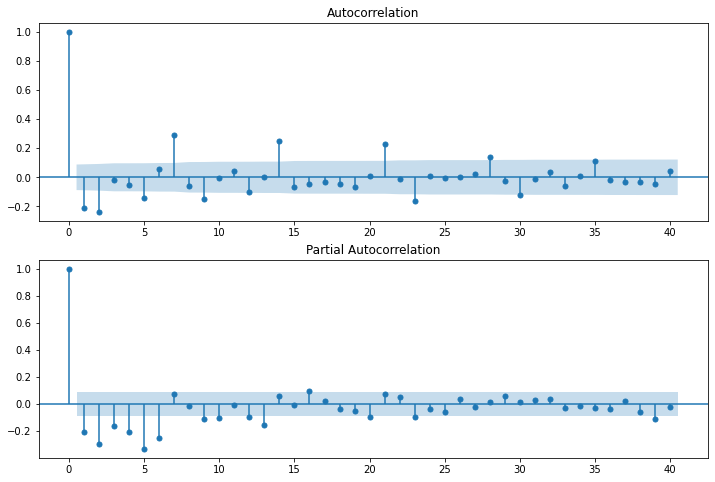

In [158]:
#Model Chosen 'first_difference'
#test_stationarity(df['first_difference'].dropna(inplace=False))

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax2)

In [159]:
import itertools

def gridsearch_sarima():
    #set parameter range
    p = range(0,3)
    q = range(1,3)
    d = range(1,3)
    s = range(6,8)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    best_results = '' 
    best_aic = 100000000
    # SARIMA model pipeline
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'],
                                        order=param,
                                        seasonal_order=param_seasonal)
                results = mod.fit(max_iter = 50, method = 'powell')
                print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
                if results.aic < best_aic:
                    best_results = 'SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic)
                    best_aic = results.aic
                    best_param = param
                    best_param_seasonal = param_seasonal
            except:
                continue

    print('Best Results: SARIMA{},{} - AIC:{}'.format(best_param,best_param_seasonal, best_aic))
    return best_param, best_param_seasonal

In [160]:
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1

#order, seasonal_order = gridsearch_sarima() 
    
#BEST PARAMETERS GRID_SEARCH
order_sarima = (1, 1, 1)
seasonal_order = (2, 1, 1, 7)    

mod_sarima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], order=order_sarima,seasonal_order=seasonal_order,simple_differencing=True)
results_sarima = mod_sarima.fit(max_iter = 50, method = 'powell')
results_sarima.summary()


Optimization terminated successfully.
         Current function value: 2.903900
         Iterations: 9
         Function evaluations: 656


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     D.DS7.Germany/Luxembourg[€/MWh]   No. Observations:                  603
Model:               SARIMAX(1, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -1751.051
Date:                             Fri, 08 Jan 2021   AIC                           3514.103
Time:                                     09:30:48   BIC                           3540.514
Sample:                                 04-08-2019   HQIC                          3524.382
                                      - 11-30-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4267      0.045      9.511      0.000       0.339       0.515
ma.L1         -0.9545      0.036    -26.584      0.000      -1.025      -0.884
ar.S.L7        0.0663      0.047      1.400      0.161      -0.026       0.159
ar.S.L14       0.0953      0.047      2.036      0.042       0.004       0.187
ma.S.L7       -0.9437      0.033    -28.266      0.000      -1.009      -0.878
sigma2        33.8627      1.847     18.332      0.000      30.242      37.483
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               146.19
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.64
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

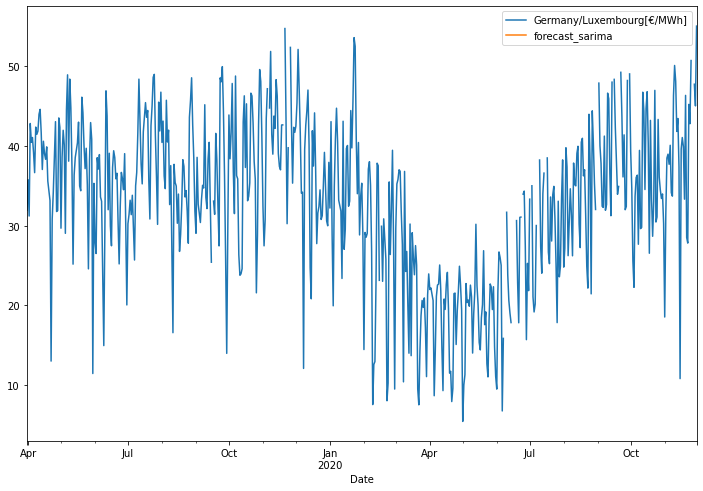

In [161]:
df_normal['forecast_sarima'] = results_sarima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima']].plot(figsize=(12, 8))

In [162]:
def gridsearch_arima():
    import itertools
    #set parameter range
    p = range(0,6)
    q = range(0,6)
    d = range(0,6)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    best_results = '' 
    best_aic = 100000000
    # ARIMA model pipeline
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'],
                                            order=param, 
                                            enforce_invertibility=False)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            if results.aic < best_aic:
                best_results = 'ARIMA{} - AIC:{}'.format(param,results.aic)
                best_aic = results.aic
                best_param = param
        except:
            continue

    print('Best Results: ARIMA{} - AIC:{}'.format(best_param, best_aic))
    return best_param

In [163]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1

#order =  gridsearch_arima() #1 to get the first difference
order_arima = (4, 1, 5)
mod_arima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order_arima)
results_arima = mod_arima.fit()
results_arima.summary()

/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Germany/Luxembourg[€/MWh]   No. Observations:                  611
Model:                      SARIMAX(4, 1, 5)   Log Likelihood               -1901.149
Date:                       Fri, 08 Jan 2021   AIC                           3822.299
Time:                               09:30:50   BIC                           3866.434
Sample:                           03-31-2019   HQIC                          3839.467
                                - 11-30-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7530      0.023     32.368      0.000       0.707       0.799
ar.L2         -1.3986      0.019    -74.711      0.000      -1.435      -1.362
ar.L3          0.7782      0.020     39.551      0.000       0.740       0.817
ar.L4         -0.9337      0.022    -41.992      0.000      -0.977      -0.890
ma.L1         -1.3373      0.042    -31.484      0.000      -1.421      -1.254
ma.L2          1.6956      0.055     31.030      0.000       1.588       1.803
ma.L3         -1.6003      0.053    -29.920      0.000      -1.705      -1.495
ma.L4          1.2079      0.056     21.574      0.000       1.098       1.318
ma.L5         -0.5726      0.041    -13.922      0.000      -0.653      -0.492
sigma2        36.9993      1.694     21.841      0.000      33.679      40.320
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):               111.19
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.58
Prob(H) (two-sided):                  0.43   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

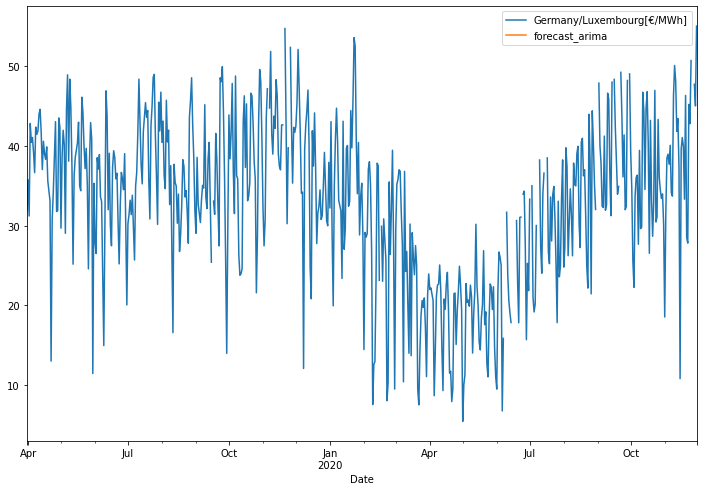

In [164]:
df_normal['forecast_arima'] = results_arima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_arima']].plot(figsize=(12, 8))

<AxesSubplot:xlabel='Date'>

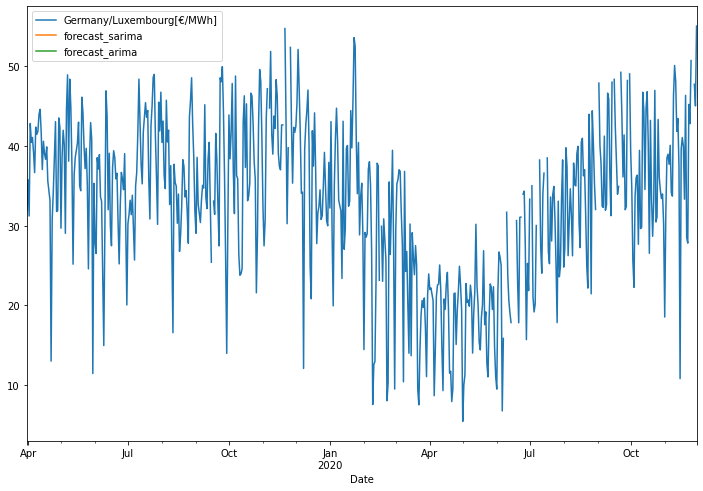

In [165]:
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima', 'forecast_arima']].plot(figsize=(12, 8))

In [166]:
df_test['forecast_arima'] = results_arima.predict(start = '2020-12-01', end='2020-12-31')
df_test['forecast_sarima'] = results_sarima.predict(start = '2020-12-01', end='2020-12-31')
df_test

,Germany/Luxembourg[€/MWh],forecast_arima,forecast_sarima
Date,,,
2020-12-01,57.650,53.578223,2.164027
2020-12-02,80.345,46.928864,-8.493875
2020-12-03,48.730,47.798601,5.341958
2020-12-04,40.560,50.825192,2.592855
2020-12-05,45.630,44.054810,0.491932
2020-12-06,39.910,41.609046,-1.036513
2020-12-07,41.595,50.779597,4.113354
2020-12-08,66.085,53.010955,-1.235729
2020-12-09,79.180,46.283618,-0.130172


In [167]:
#MSE
#MAE
#AMAPE

MSE_arima=np.sum((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_arima=np.sum(np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_arima= np.sum((np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_sarima=np.sum((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_sarima=np.sum(np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_sarima= np.sum((np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100


print('ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_arima,MAE_arima,MAPE_arima))
print('SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_sarima,MAE_sarima,MAPE_sarima))

ARIMA MODEL: 
  MSE: 197.59276326164195 
  MAE: 9.64314007039254 
  MAPE: 31.386027135811823 

SARIMA MODEL: 
  MSE: 2407.5461317036647 
  MAE: 46.648206081913294 
  MAPE: 99.50544367870373 



<AxesSubplot:xlabel='Date'>

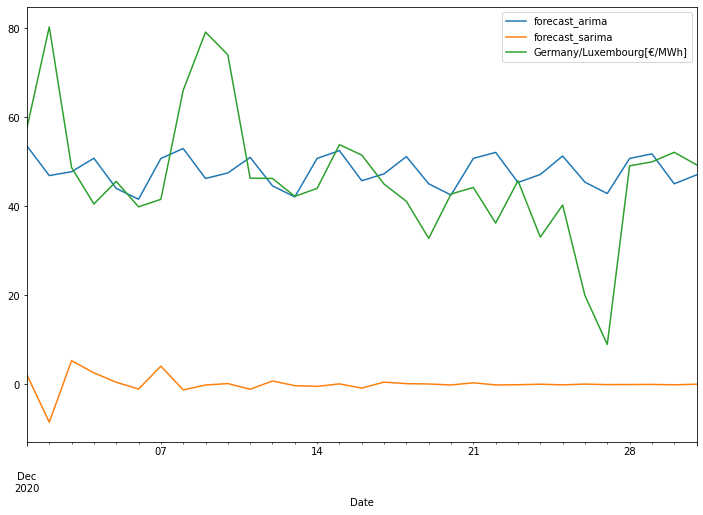

In [168]:
df_test[['forecast_arima','forecast_sarima', 'Germany/Luxembourg[€/MWh]']].plot(figsize=(12, 8))

In [169]:
df_test['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_test['residual_arima'] = df_test['Germany/Luxembourg[€/MWh]']- df_test['forecast_arima']
df_test['residual_sarima'] = df_test['Germany/Luxembourg[€/MWh]']- df_test['forecast_sarima']
df_test['residual_sarima'].dropna(inplace=True)
df_test['residual_arima'].dropna(inplace=True)

#Start the (G)arch Model
from arch import arch_model

#Now we can fit the arch model using the best fit arima model parameters
p_ = order_arima[0]
o_ = order_arima[1]
q_ = order_arima[2]

# Using student T distribution usually provides better fit
garch_arima = arch_model(df_test['residual_arima'], p=p_, o=o_, q=q_  , dist='StudentsT')
res_garch_arima = garch_arima.fit(update_freq=5, disp='off')
print(res_garch_arima.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:               residual_arima   R-squared:                      -0.003
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                        GJR-GARCH   Log-Likelihood:               -123.013
Distribution:      Standardized Student's t   AIC:                           272.026
Method:                  Maximum Likelihood   BIC:                           290.668
                                              No. Observations:                   31
Date:                      Fri, Jan 08 2021   Df Residuals:                       18
Time:                              09:30:52   Df Model:                           13
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -1

In [171]:
#Get Mean Arima
predicted_mu_arima = mod_arima.predict(n_periods=30)[0]
garch_arima_forecast = garch_arima.forecast(horizon=30)


predicted_et_arima = garch_arima_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction_garch_arima = predicted_mu_arima + predicted_et_arima

df_test['prediction_garch_arima'] = prediction_garch_arima

TypeError: predict() missing 1 required positional argument: 'params'

In [ ]:
#Now we can fit the arch model using the best fit sarima model parameters
p_ = order_sarima[0]
o_ = order_sarima[1]
q_ = order_sarima[2]

# Using student T distribution usually provides better fit
garch_sarima = arch_model(df_test['residual_sarima'], p=p_, o=o_, q=q_  , dist='StudentsT')
res_arch_sarima = garch_sarima.fit(update_freq=5, disp='off')
print(res_arch_sarima.summary())


In [ ]:
#Get Mean Arima
predicted_mu_sarima = mod_sarima.predict(n_periods=1)[0]

garch_sarima_forecast = garch_sarima.forecast(horizon=30)
predicted_et_sarima = garch_sarima_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction_garch_sarima = predicted_mu_sarima + predicted_et_sarima

df_test['prediction_garch_sarima'] = prediction_garch_sarima

In [ ]:
df_test

In [ ]:
df_test[['Germany/Luxembourg[€/MWh]','forecast_arima','forecast_sarima', 'prediction_garch_sarima','prediction_garch_arima']].plot()

AttributeError: 'SARIMAX' object has no attribute 'summary'